# CROCO 3D tutorial

This tutorial will show how to run a 3D simulation with output from the CROCO model.

## Example setup

We start with loading the relevant modules and the data.

In [1]:
import os
import parcels
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr

example_dataset_folder = parcels.download_example_dataset("CROCOidealized_data")
file = os.path.join(example_dataset_folder, "CROCO_idealized.nc")

The simulation will be a very simple, idealised flow: a purely zonal flow over a sloping bottom. This flow (which is somewhat unrealistic of course) nicely showcases that particles stay on their initial depth levels, even though the sigma-layers slope down. 

This flow has been created by first running the example from the [Shelf front example on the CROCO website](https://croco-ocean.gitlabpages.inria.fr/croco_doc/model/model.test_cases.shelfront.html). Then, we took the restart file are manually replaced all the `u`-velocities with `1` m/s and all the `v`-velocities with `0` m/s. This way we get a purely zonal flow. We then started a new simulation from the restart file, and CROCO then automatically calculated the `w` velocities to match the new zonal field. We saved the `time=0` snapshot from this new run and use it below.

Now we create a FieldSet object using the `FieldSet.from_croco()` method. Note that CROCO is a C-grid (with similar indexing at MITgcm), so we need to provide the longitudes and latitudes of the $\rho$-points of the grid (`lon_rho` and `lat_rho`). We also need to provide the sigma levels at the depth points (`s_w`). Finally, it is important to also provide the bathymetry field (`h`), which is needed to convert the depth levels of the particles to sigma-coordinates.

<div class="alert alert-info">

__Note__ that in the code below we use the `w` velocity field for vertical velocity. However, it is unclear whether this is always the right choice. CROCO (and ROMS) also output an `omega` field, which may be more appropriate to use. The idealised simulation below only works when using `w`, though. In other simulations, it is recommended to test whether `omega` provides more realistic results. See https://github.com/OceanParcels/Parcels/discussions/1728 for more information.
</div>

In [2]:
variables = {"U": "u", "V": "v", "W": "w", "H": "h", "Zeta": "zeta", "Cs_w": "Cs_w"}

lon_rho = "x_rho"  # Note, this would be "lon_rho" for a dataset on a spherical grid
lat_rho = "y_rho"  # Note ,this would be "lat_rho" for a dataset on a spherical grid

dimensions = {
    "U": {"lon": lon_rho, "lat": lat_rho, "depth": "s_w", "time": "time"},
    "V": {"lon": lon_rho, "lat": lat_rho, "depth": "s_w", "time": "time"},
    "W": {"lon": lon_rho, "lat": lat_rho, "depth": "s_w", "time": "time"},
    "H": {"lon": lon_rho, "lat": lat_rho},
    "Zeta": {"lon": lon_rho, "lat": lat_rho, "time": "time"},
    "Cs_w": {"depth": "s_w"},
}
fieldset = parcels.FieldSet.from_croco(
    file,
    variables,
    dimensions,
    hc=xr.open_dataset(
        file
    ).hc.values,  # Note this stretching parameter is needed for the vertical grid
    allow_time_extrapolation=True,  # Note, this is only needed for this specific example dataset, that has only one snapshot
    mesh="flat",  # Note, this is only needed for this specific example dataset, that has been created on a 'flat' mesh (i.e. in km instead of in degrees)
)

Now we can use this Fieldset to advect particles as we would normally do. Note that the particle depths should be provided in (negative) meters, not in sigma-coordinates.

In [3]:
X, Z = np.meshgrid(
    [40e3, 80e3, 120e3],
    [100, -10, -130, -250, -400, -850, -1400, -1550],
)
Y = np.ones(X.size) * fieldset.U.grid.lat[25]


def DeleteParticle(particle, fieldset, time):
    if particle.state >= 50:
        particle.delete()


pset = parcels.ParticleSet(
    fieldset=fieldset, pclass=parcels.JITParticle, lon=X, lat=Y, depth=Z
)

outputfile = pset.ParticleFile(name="croco_particles3D.zarr", outputdt=5000)

pset.execute(
    [parcels.AdvectionRK4_3D, DeleteParticle],
    runtime=5e4,
    dt=100,
    output_file=outputfile,
)

INFO: Output files are stored in croco_particles3D.zarr.
100%|██████████| 50000.0/50000.0 [00:00<00:00, 131009.03it/s]


Now we plot the particle trajectories below. Note that the particles stay on their initial depth levels, even though the sigma-layers slope down. Also note that particles released above the surface (where depth >0) or below the bathymetry are not advected (due to the `DeleteParticle` kernel).

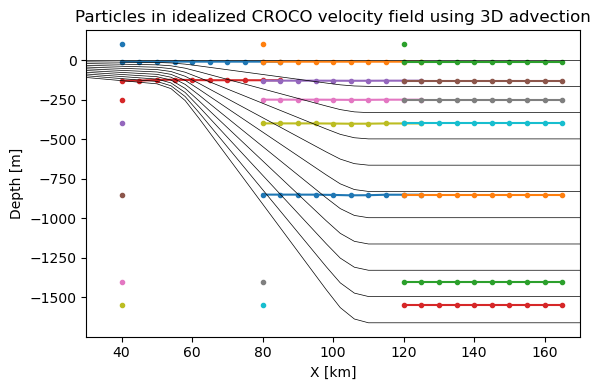

In [4]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ds = xr.open_zarr("croco_particles3D.zarr")

ax.plot(ds.lon.T / 1e3, ds.z.T, ".-")

dsCROCO = xr.open_dataset(file)
for z in dsCROCO.s_w.values:
    ax.plot(fieldset.H.lon / 1e3, fieldset.H.data[0, 25, :] * z, "k", linewidth=0.5)
ax.set_xlabel("X [km]")
ax.set_xlim(30, 170)
ax.set_ylabel("Depth [m]")
ax.set_title("Particles in idealized CROCO velocity field using 3D advection")
plt.tight_layout()
plt.show()

### A CROCO simulation with no vertical velocities

It may be insightful to compare this 3D run with the `AdvectionRK4_3D` kernel with a run where the vertical velocity (`W`) is set to zero. In that case, the particles will not stay on their initial depth levels but instead follow sigma-layers.

INFO: Output files are stored in croco_particles_noW.zarr.
100%|██████████| 50000.0/50000.0 [00:00<00:00, 132723.16it/s]


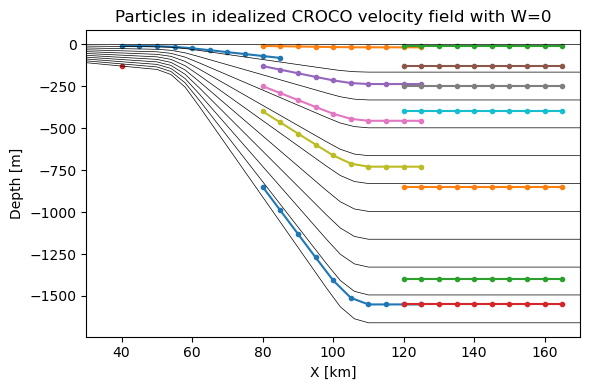

In [5]:
import copy

fieldset_noW = copy.copy(fieldset)
fieldset_noW.W.data[:] = 0.0

pset_noW = parcels.ParticleSet(
    fieldset=fieldset_noW, pclass=parcels.JITParticle, lon=X, lat=Y, depth=Z
)

outputfile = pset.ParticleFile(name="croco_particles_noW.zarr", outputdt=5000)

pset_noW.execute(
    [parcels.AdvectionRK4_3D, DeleteParticle],
    runtime=5e4,
    dt=100,
    output_file=outputfile,
)

fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ds = xr.open_zarr("croco_particles_noW.zarr")

ax.plot(ds.lon.T / 1e3, ds.z.T, ".-")

dsCROCO = xr.open_dataset(file)
for z in dsCROCO.s_w.values:
    ax.plot(fieldset.H.lon / 1e3, fieldset.H.data[0, 25, :] * z, "k", linewidth=0.5)
ax.set_xlabel("X [km]")
ax.set_xlim(30, 170)
ax.set_ylabel("Depth [m]")
ax.set_title("Particles in idealized CROCO velocity field with W=0")
plt.tight_layout()
plt.show()

## The algorithms used

When using `FieldSet.from_croco()`, Parcels knows that depth needs to be converted to sigma-coordinates, before doing any interpolation. This is done under the hood, using code for interpolation (in this case a `T` Field) like
```python
# First calculate local sigma level of the particle, by linearly interpolating the scaling function that maps sigma to depth (using local ocean depth H, sea-surface Zeta and stretching parameters Cs_w and hc). See also https://croco-ocean.gitlabpages.inria.fr/croco_doc/model/model.grid.html#vertical-grid-parameters
h = fieldset.H[time, 0, particle.lat, particle.lon]
zeta = fieldset.H[time, 0, particle.lat, particle.lon]
sigma_levels = fieldset.U.grid.depth
z0 = fieldset.hc * sigma_levels + (h - fieldset.hc) * fieldset.Cs_w
zvec = z0 + zeta * (1 + (z0 / h))
zinds = zvec <= z
if z >= zvec[-1]:
    zi = len(zvec) - 2
else:
    zi = zinds.argmin() - 1 if z >= zvec[0] else 0

sigma = sigma_levels[zi] + (z - zvec[zi]) * (sigma_levels[zi + 1] - sigma_levels[zi]) / (zvec[zi + 1] - zvec[zi])

# Now interpolate the field to the sigma level
temp = fieldset.T[time, sigma, particle.lat, particle.lon]
```

For the `AdvectionRK4_3D` kernel, Parcels will replace the kernel with `AdvectionRK4_3D_CROCO`, which works slightly different from the normal 3D advection kernel because it converts the vertical velocity in sigma-units. The conversion from depth to sigma is done at every time step, using the code shows above.

In particular, the following algorithm is used (note that the RK4 version is slightly more complex than this Euler-Forward version, but the idea is identical)

```python
(u, v, w) = fieldset.UVW[time, particle.depth, particle.lat, particle.lon, particle]  

# scaling the w with the sigma level of the particle
w_sigma = w * sigma / fieldset.H[time, particle.depth, particle.lat, particle.lon]

lon_new = particle.lon + u*particle.dt
lat_new = particle.lat + v*particle.dt

# calculating new sigma level
sigma_new = sigma + w_sigma*particle.dt 

# Converting back from sigma to depth, at _new_ location
depth_new = sigma_new * fieldset.H[time, particle.depth, lat_new, lon_new]
```